<a href="https://colab.research.google.com/github/testedaisa/markowitz-risco/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split

In [26]:
class ReturnsPredictor:
    def __init__(self):
        ### Definindo parametros de treinamento
        self.EPOCHS = 30
        self.num_companies = 4
        self.look_back = 5
        self.horizon = 1
        self.num_periods = 5

    def __build_model(self):
        self.model = keras.Sequential([
            keras.layers.LSTM(4, activation = "sigmoid", dropout = 0.1, recurrent_dropout = 0.1),
            keras.layers.Dense(4, activation = "sigmoid")])

        self.model.compile(loss='mean_squared_error', optimizer='RMSProp', metrics = ["accuracy"])

    def __processData(self, data, look_back, horizon, num_ativos, jump = 1):
        X, Y = [], []
        for i in range(0, len(data) - look_back - horizon + 1, jump):
            X.append(data[i:(i+look_back)])
            Y.append(data[(i+look_back):(i+look_back+horizon)])
        return np.array(X), np.array(Y)

    def fit(self, df):
        self.__build_model()

        array = [df.iloc[:,0], df.iloc[:,1], df.iloc[:,2], df.iloc[:,3]]
        array = np.transpose(array)

        division = len(array) - (self.num_periods*self.horizon)

        array_train = array[:division]

        X, Y = self.__processData(array_train, self.look_back, self.horizon, self.num_companies)
        Y = np.array([list(x.ravel()) for x in Y])

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 31)

        history = self.model.fit(X_train,Y_train,epochs=self.EPOCHS,validation_data=(X_test,Y_test),shuffle=True,batch_size=1, verbose=2)

        plt.figure(figsize = (15,10))
        plt.plot(history.history['loss'], label='loss')
        plt.legend(loc='best')
        plt.xlabel('Epochs')
        plt.ylabel('Loss Function Value')
        plt.show()

    def predictNext(self, df):
        last_returns = [df.iloc[-5:, 0], df.iloc[-5:, 1], df.iloc[-5:, 2], df.iloc[-5:, 3]]
        last_returns = np.transpose(last_returns)

        P = []
        P.append(last_returns[0:5])
        P = np.array(P)

        return pd.DataFrame(self.model.predict(P))

In [29]:
class Optimizer:
    def __init__(self, N, activation, optimizer, neurons):
        self.data = None
        self.model = None
        self.N = N
        self.activation = activation
        self.optimizer = optimizer
        self.neurons = neurons



    def __build_model(self, input_shape, outputs):
        model = Sequential([
            LSTM(self.neurons, input_shape=input_shape, activation = self.activation[0]),
            Dense(outputs, activation = self.activation[1])
        ])

        model.add(keras.layers.Dropout(0.1))

        def sharpe_loss(_, y_pred):
            coeffs = tf.tile(y_pred, (self.data.shape[0], 1))

            portfolio_values = tf.reduce_sum(tf.multiply(coeffs, self.data), axis=1)

            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

            return K.exp(-sharpe)

        model.compile(loss=sharpe_loss, optimizer = self.optimizer, run_eagerly=True)
        model.summary()

        return model

    def get_allocations(self, data):
        # transforma serie de precos em retornos0
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)

        data = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)

        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))

        fit_predict_data = data_w_ret[np.newaxis,:]
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=self.N, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [27]:
class Markowitz:
    def __init__(self, df):
        self.df = df
        self.retorno_esperado = df.mean()
        self.cov = df.cov()
        self.tam = len(df.columns)

        self.carteira = None
        self.risco = None
        self.retorno = None

    def set_retorno_esperado(self, retorno_esperado):
        self.retorno_esperado = retorno_esperado

    def __randCart(self):
        res = np.exp(np.random.randn(self.tam))
        res = res / res.sum()
        return res

    def retCart(self, cart):
        return np.matmul(self.retorno_esperado.values, cart)

    def riscoCart(self, cart):
        return np.sqrt(np.matmul(np.matmul(cart, self.cov.values), cart))


    def calcula(self, N):
        self.risco = np.zeros(N)
        self.retorno = np.zeros(N)
        self.carteira = np.zeros((N, self.tam))

        for n in range(N):
            cart = self.__randCart()
            self.carteira[n,:] = cart
            self.risco[n] = self.riscoCart(cart)
            self.retorno[n] = self.retCart(cart)

    def melhor(self):
        otimo = np.argmax(self.retorno/self.risco)
        return {
            'sharpe': self.retorno[otimo]/self.risco[otimo],
            'risco': self.risco[otimo],
            'retorno': self.retorno[otimo],
            'carteira': self.carteira[otimo]
        }


    def plot(self, label=None, cart=None):
        plt.figure()

        plt.scatter(self.risco*100, self.retorno*100, c='y', marker='.')
        plt.xlabel('Risco esperado %')
        plt.ylabel('Retorno esperado %')
        plt.title('Fronteira eficiente')

        melhor = self.melhor()
        plt.scatter([melhor['risco']*100],[melhor['retorno']*100],c='g',marker='o',label=f'Markowitz: {melhor["sharpe"]:.02f}')

        if label != None:
            risco = self.riscoCart(cart)
            retorno = self.retCart(cart)
            sharpe = retorno / risco
            plt.scatter([risco*100],[retorno*100], c='b',marker='x',label=f'{label}: {sharpe:.02f}')

        plt.legend()
        plt.show()

    def print(self, label=None, cart=None):

        melhor = self.melhor()


        print('---------- Portfolio Markowitz ----------')
        print()
        print(" Risco esperado = %1.2f%%" % (float(melhor['risco'])*100.))
        print(" Retorno esperado = %1.2f%%" % (float(melhor['retorno'])*100.))
        print()
        print(pd.DataFrame([melhor['carteira']*100],columns=df.columns,index=[', %']).T)
        print()

        if label != None:
            risco = self.riscoCart(cart)
            retorno = self.retCart(cart)

            print(f'---------- Portfolio {label} ----------')
            print()
            print(" Risco esperado = %1.2f%%" % (float(risco)*100.))
            print(" Retorno esperado = %1.2f%%" % (float(retorno)*100.))
            print()
            print(pd.DataFrame([cart*100],columns=df.columns,index=[', %']).T)
            print()


Epoch 1/30
66/66 - 2s - loss: 0.2482 - accuracy: 0.5758 - val_loss: 0.2147 - val_accuracy: 0.7647 - 2s/epoch - 25ms/step
Epoch 2/30
66/66 - 0s - loss: 0.2025 - accuracy: 0.5758 - val_loss: 0.1738 - val_accuracy: 0.7647 - 159ms/epoch - 2ms/step
Epoch 3/30
66/66 - 0s - loss: 0.1619 - accuracy: 0.5758 - val_loss: 0.1379 - val_accuracy: 0.7647 - 163ms/epoch - 2ms/step
Epoch 4/30
66/66 - 0s - loss: 0.1268 - accuracy: 0.5758 - val_loss: 0.1071 - val_accuracy: 0.7647 - 203ms/epoch - 3ms/step
Epoch 5/30
66/66 - 0s - loss: 0.0977 - accuracy: 0.5758 - val_loss: 0.0822 - val_accuracy: 0.7647 - 166ms/epoch - 3ms/step
Epoch 6/30
66/66 - 0s - loss: 0.0737 - accuracy: 0.5758 - val_loss: 0.0622 - val_accuracy: 0.7647 - 168ms/epoch - 3ms/step
Epoch 7/30
66/66 - 0s - loss: 0.0551 - accuracy: 0.5758 - val_loss: 0.0471 - val_accuracy: 0.7647 - 187ms/epoch - 3ms/step
Epoch 8/30
66/66 - 0s - loss: 0.0406 - accuracy: 0.5758 - val_loss: 0.0365 - val_accuracy: 0.7647 - 158ms/epoch - 2ms/step
Epoch 9/30
66/66 -

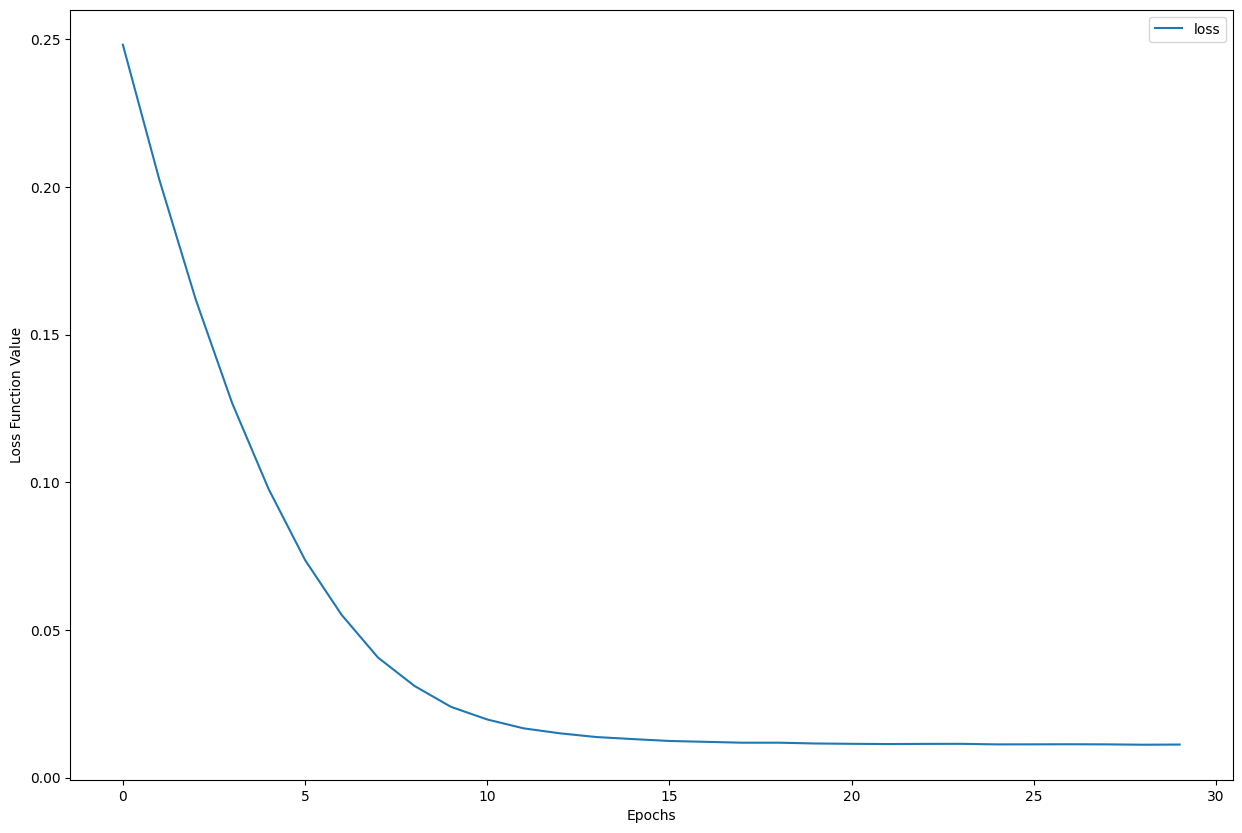

1/1 [==============================] - 0s 300ms/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 208       
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
Total params: 228
Trainable params: 228
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 415ms/step - loss: 0.6115
Epoch 2/100
1/1 [==============================] - 0s 258ms/step - loss: 0.6111
Epoch 3/100
1/1 [==============================] - 0s 263ms/step - loss: 0.6108
Epoch 4/100
1/1 [==========

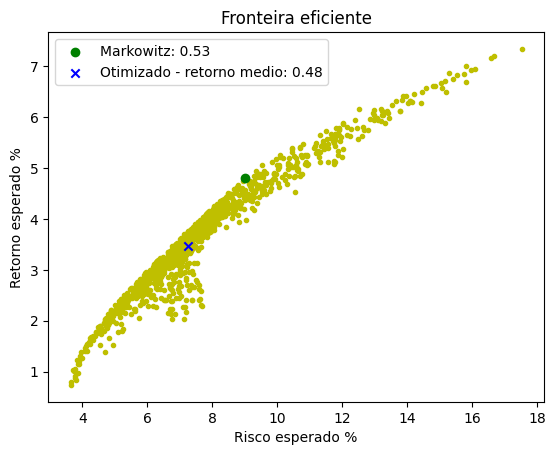

---------- Portfolio Markowitz ----------

 Risco esperado = 9.02%
 Retorno esperado = 4.80%

                      , %
S&P500          21.609352
T Bill           2.787700
T Bonds          6.165776
Baa Corp Bonds  69.437171

---------- Portfolio Otimizado - retorno medio ----------

 Risco esperado = 7.26%
 Retorno esperado = 3.47%

                      , %
S&P500           5.011001
T Bill          10.616850
T Bonds         26.072773
Baa Corp Bonds  58.299374



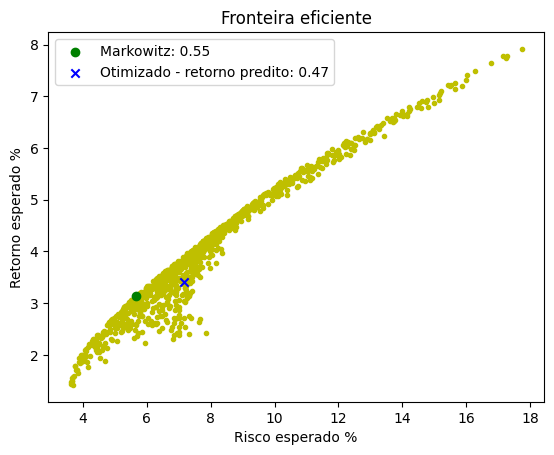

---------- Portfolio Markowitz ----------

 Risco esperado = 5.66%
 Retorno esperado = 3.13%

                      , %
S&P500          18.205982
T Bill          52.470616
T Bonds          8.633335
Baa Corp Bonds  20.690067

---------- Portfolio Otimizado - retorno predito ----------

 Risco esperado = 7.17%
 Retorno esperado = 3.40%

                      , %
S&P500           5.011001
T Bill          10.616850
T Bonds         26.072773
Baa Corp Bonds  58.299374



In [30]:
#importa os dados
df = pd.read_excel ('/content/drive/My Drive/Databases/markowitz-dataset/ativos.xlsx', header = 0)
year = df.pop('Year')

# retorno esperado via rede
predictor = ReturnsPredictor()
predictor.fit(df)
retorno_esperado = predictor.predictNext(df)

# cria serie de preços q respeita os retornos
df_pu = pd.DataFrame([[1, 1, 1, 1]])
df_pu.columns = df.columns
for i in range(1, len(df)+1):
    df_pu.loc[i,:] = df_pu.loc[i-1,:] *(1 + df.loc[i-1,:])

# calcula o portfolio ótimo usando otimizador
model = Optimizer(N = 100, activation = ['sigmoid', 'softmax'], optimizer = 'RMSProp', neurons = 4)
cart_lstm = model.get_allocations(df_pu)

markClassico = Markowitz(df[1:-1])
markClassico.calcula(1000)
markClassico.plot('Otimizado - retorno medio', cart_lstm)
markClassico.print('Otimizado - retorno medio', cart_lstm)

# concatena o retorno esperado no dataframe
retorno_esperado.columns = df.columns
df = pd.concat([df, retorno_esperado], ignore_index=True)

# calcula o portfolio ótimo usando o modelo de markowitz
mark = Markowitz(df)
mark.set_retorno_esperado(retorno_esperado.iloc[0])
mark.calcula(1000)
mark.plot('Otimizado - retorno predito', cart_lstm)
mark.print('Otimizado - retorno predito', cart_lstm)